In [1]:
%matplotlib notebook

# Non Max Suppression (NMS) in PyTorch
Today we'll see how to implement non max suppression in PyTorch

## Preambula

If you are doing computer vision (expecially object detection), you know what *non max suppression (nms)* is. There are a lot of good articles online giving a good overview. In a nutshell, *non max suppression* reduce the numbers of outputed bounding boxes using some heuristics.

From [`PyTorch` doc](https://pytorch.org/vision/stable/generated/torchvision.ops.nms.html) 

>NMS iteratively removes lower scoring boxes which have an IoU greater than iou_threshold with another (higher scoring) box.

[This is an amazing article](https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c) from [ Sambasivarao K](https://medium.com/@SambasivaraoK) that goes trough *nms*, givin you a very good idea of what it does.

Now assume we know what it does, let's see how it works.

## Example

Let's load up an image and some bounding boxes

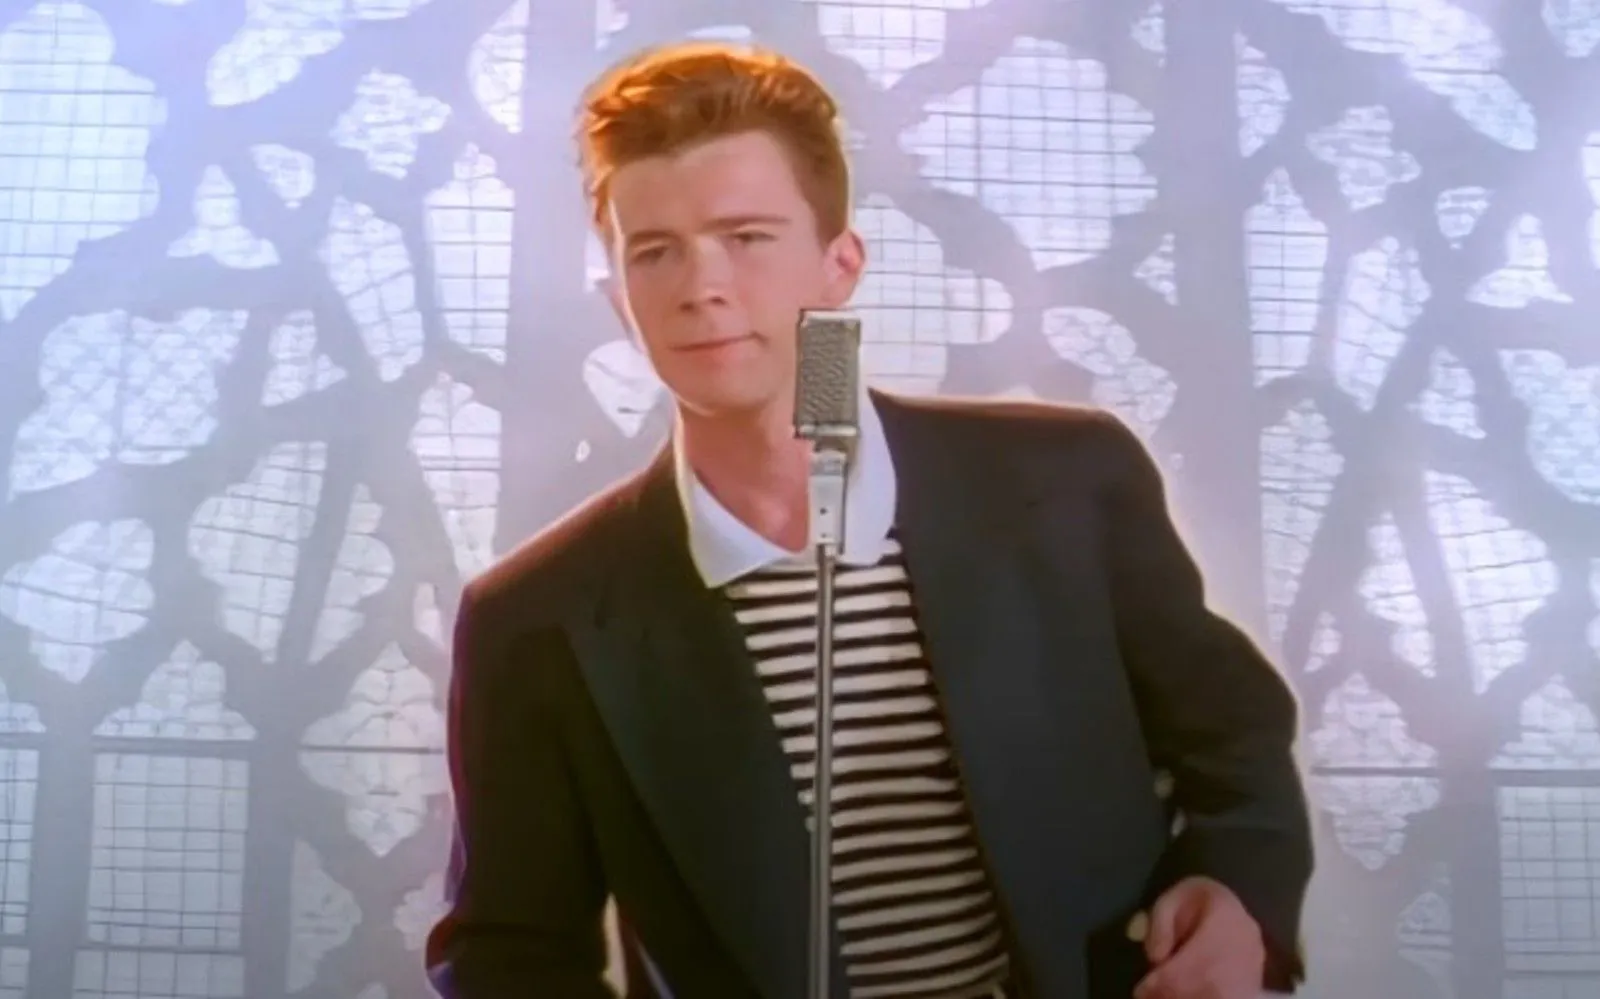

In [2]:
from PIL import Image
import torch
import matplotlib.pyplot as plt
import numpy as np
# credit https://i0.wp.com/craffic.co.in/wp-content/uploads/2021/02/ai-remastered-rick-astley-never-gonna-give-you-up.jpg?w=1600&ssl=1

img = Image.open("./images/never-gonna-give-you-up.webp")
img

Let me create two `bboxes`, one for the `head` and one for the `mic` 

In [3]:
original_bboxes = torch.tensor([
    # head
    [ 565, 73, 862, 373],
    # mic
    [807, 309, 865, 434]
]).float()

w, h = img.size
# we need them in range [0, 1]
original_bboxes[...,0] /= h
original_bboxes[...,1] /= w
original_bboxes[...,2] /= h
original_bboxes[...,3] /= w

We have the `bboxes` in `[0, 1]` range, this is not necessary but it's useful when you have multiple classes.

<IPython.core.display.Javascript object>


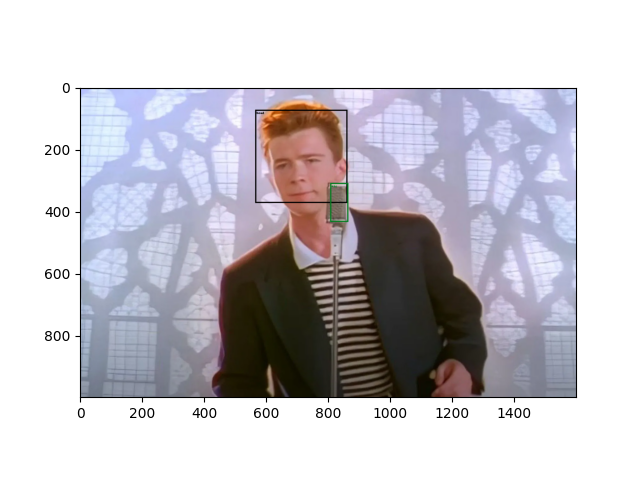

In [4]:
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_tensor
from typing import List

def plot_bboxes(img : Image.Image, bboxes: torch.Tensor, *args, **kwargs) -> plt.Figure:
    w, h = img.size
    # from [0, 1] to image size
    bboxes = bboxes.clone()
    bboxes[...,0] *= h
    bboxes[...,1] *= w
    bboxes[...,2] *= h
    bboxes[...,3] *= w
    fig = plt.figure()
    img_with_bboxes = draw_bounding_boxes((to_tensor(img) * 255).to(torch.uint8), bboxes, *args, **kwargs, width=4)
    return plt.imshow(img_with_bboxes.permute(1,2,0).numpy())

plot_bboxes(img, original_bboxes, labels=["head", "mic"])

Let's add more overlapping bboxes

<IPython.core.display.Javascript object>


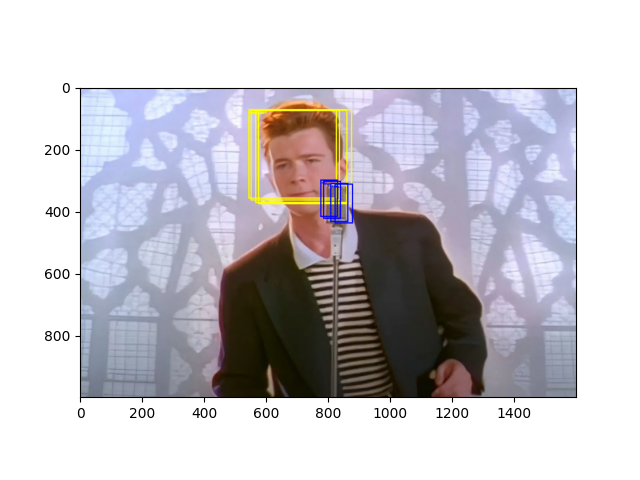

In [35]:
max_bboxes = 3
scaling = torch.tensor([1, .96, .97, 1.02])
shifting = torch.tensor([0, 0.001, 0.002, -0.002])

# broadcasting magic (2, 1, 4) * (1, 3, 1)
bboxes = (original_bboxes[:,None,:] * scaling[..., None] + shifting[..., None]).view(-1, 4)

plot_bboxes(img, bboxes, colors=[*["yellow"] * 4, *["blue"] * 4], labels=[*["head"] * 4, *["mic"] * 4])

Okay, messy enough. We now have six `bboxes`. Let's also define `scores`, this is usually outputed from the model.

In [36]:
scores = torch.tensor([
    0.98, 0.85, 0.5, 0.2, # for head
    1, 0.92, 0.3, 0.1 # for mic
])

and our `labels`, `0` for *head*, `1` for *mic*

In [37]:
labels = torch.tensor([0,0,0,0,1,1,1,1])

Let's permute the data

In [38]:
perm = torch.randperm(scores.shape[0])

In [39]:
bboxes = bboxes[perm]
scores = scores[perm]
labels = labels[perm]

Let's see them

<IPython.core.display.Javascript object>


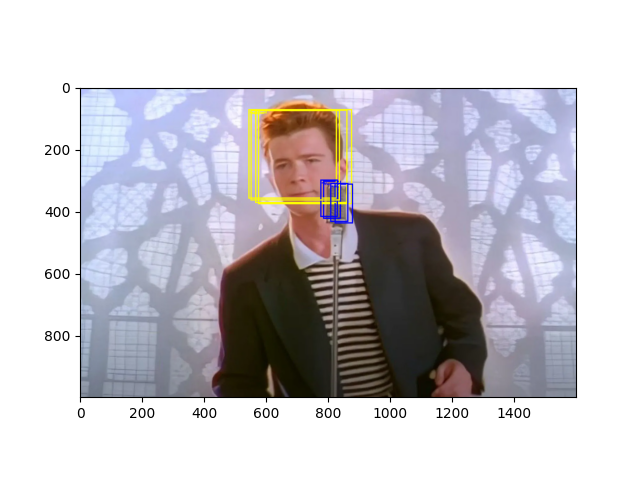

In [40]:
plot_bboxes(img, bboxes, 
            colors=["yellow" if el.item() == 0 else "blue" for el in labels], 
            labels=["head" if el.item()  == 0 else "mic" for el in labels]
           )

good!

## Implementation

So NMS works by iteratevely removing low score overlapping bounding boxes. So, the steps are the following

```
bboxes are sorted by score in decresing order
init a vector keep with ones
for i in len(bboxes):
    # was suppressed
    if keep[i] == 0:
        continue
    # compare with all the others
    for j in len(bbox):
        if (iou(bboxes[i], bboxes[j]) > iou_threshold):
            keep[j] = 0
    
return keep
```

Mimicing the torch implementation, our `nms` takes three parameters (actually copied and pasted from torch's doc):

- boxes (Tensor[N, 4])) – boxes to perform NMS on. They are expected to be in (x1, y1, x2, y2) format with 0 <= x1 < x2 and 0 <= y1 < y2.

- scores (Tensor[N]) – scores for each one of the boxes

- iou_threshold (float) – discards all overlapping boxes with IoU > iou_threshold

**we will return the indices of the non suppressed bouding boxes**

In [41]:
from torchvision.ops.boxes import box_iou, box_area

def nms(bboxes: torch.Tensor, scores: torch.Tensor, iou_threshold: float) -> torch.Tensor:
    order = torch.argsort(-scores)
    bboxes = bboxes.clone()[order]
    indices = torch.arange(bboxes.shape[0])
    keep = torch.ones_like(indices, dtype=torch.bool)
    for i in indices:
        if keep[i]:
            bbox = bboxes[i]
            iou = box_iou(bbox[None,...], (bboxes * keep[...,None])[i + 1:])
            overlapped = torch.where(iou > iou_threshold)[1]
            keep[overlapped + i + 1] = 0
    return order[keep]

let's go line by line

```python
order = scores.argsort()
```

we get the sorted indices based on `scores`

Then we make a copy and sort the `bboxes`

```python
bboxes = bboxes.clone()[order]
```

```python
indices = torch.arange(bboxes.shape[0])
```

we are creating the `indices` we will use to iterate `bboxes`

```python
keep = torch.ones_like(indices, dtype=torch.bool)
```

`keep` is a vector used to know if a `bbox` should be kept or not, if `keep[i] == 1` then `bboxes[i]` is not suppressed

```python
for i in indices:
    ...
```
we iterate over all `bboxes`

```python
     if keep[i]:
```
if current `bbox` is not suppressed `keep[i] = 1`

```python
        bbox = bboxes[i]
```

get `bbox`

```
        iou = box_iou(bbox[None,...], (bboxes * keep[...,None])[i + 1:])
```

calculate `iou` between current `bbox` and all the others candidates. Notice two things

```python
            (bboxes * keep[...,None])
```

This will set to zero all the suppressed `bboxes` (since `keep` will be equal to `0`)

```python
            (bboxes ...)[i + 1:]
```

We need to compare with all the next `bboxes` and **we need to skip the current one**, so this is why we have a `+ 1`

```python
        overlapped = torch.where(iou > iou_threshold)[1]
```

if `iou` is greater than `iou_threshold`, we get those indices with `torch.where` (we need to take `[1]` since we are interested in the second dim)

```python
        keep[overlapped + i + 1] = 0
```

Since we sliced `bboxes` before, `(bboxes ...)[i + 1:])`, we need to add the offset to those indices, so we add `+ i + 1`.

Finally, we return `return order[keep]`, to map back to the original `bboxes` indices (non sorted)



Okay, let's try it!. Before calling `nms`, we need to sort everything by `score`

<IPython.core.display.Javascript object>


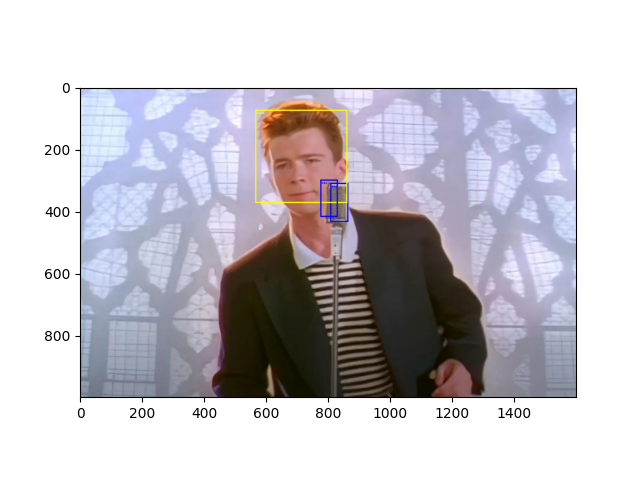

In [42]:
nms_indices = nms(bboxes, scores, .45)
plot_bboxes(img, 
            bboxes[nms_indices],
            colors=["yellow" if el.item() == 0 else "blue" for el in labels[nms_indices]], 
            labels=["head" if el.item()  == 0 else "mic" for el in labels[nms_indices]]
           )

Since we have multiple classes, we need to make our `nms` to suppressed only bboxes with the same class. There is a nice **trick**. 

Remember our `bboxes` are between `[0,1]`? Well, we can add the `labels` to them to push away `bboxes` with different classes.

We can lower `iou_threshold`

<IPython.core.display.Javascript object>


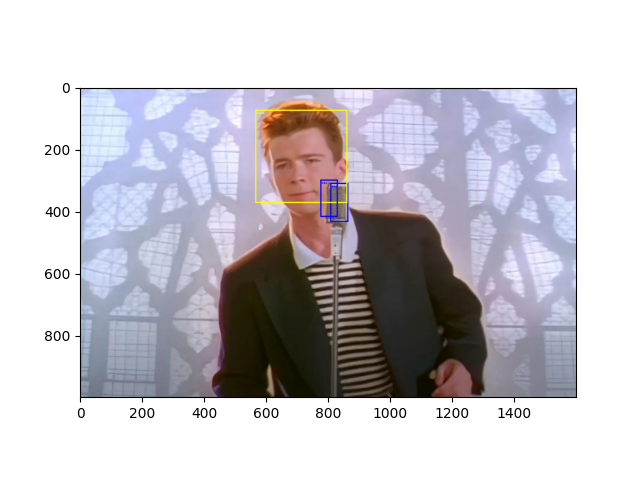

In [43]:
nms_indices = nms(bboxes + labels[..., None], scores, .45)
plot_bboxes(img, 
            bboxes[nms_indices],
            colors=["yellow" if el.item() == 0 else "blue" for el in labels[nms_indices]], 
            labels=["head" if el.item()  == 0 else "mic" for el in labels[nms_indices]]
           )

Let's check the official `torch` implementation

In [46]:
from torchvision.ops.boxes import nms as torch_nms

<IPython.core.display.Javascript object>


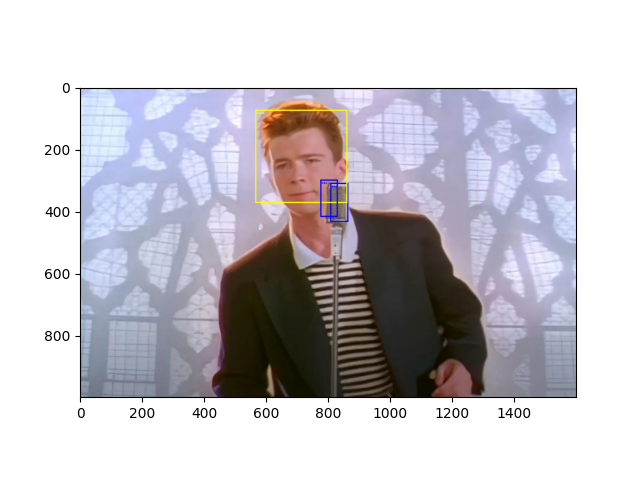

In [47]:
nms_indices = nms(bboxes + labels[..., None], scores, .45)
plot_bboxes(img, 
            bboxes[nms_indices],
            colors=["yellow" if el.item() == 0 else "blue" for el in labels[nms_indices]], 
            labels=["head" if el.item()  == 0 else "mic" for el in labels[nms_indices]]
           )

Same result!